# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from dataloader.load_regression_data_from_arbitrary_gp_varying_kernel import RegressionDataGeneratorArbitraryGPWithVaryingKernel
from nueral_process_model_conditional import ConditionalNeuralProcess
from utils.plot import plot_learning_curve
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_ds_test

# DataGenerator

In [7]:
data_generator = RegressionDataGeneratorArbitraryGPWithVaryingKernel(
    iterations=25,
    batch_size=32,
    min_num_context=3,
    max_num_context=40,
    min_num_target=2,
    max_num_target=40,
    min_x_val_uniform=-2,
    max_x_val_uniform=2,
    min_kernel_length_scale=0.1,
    max_kernel_length_scale=10.
)

In [8]:
(context_x, context_y, target_x), target_y = next(iter(data_generator.train_ds))

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

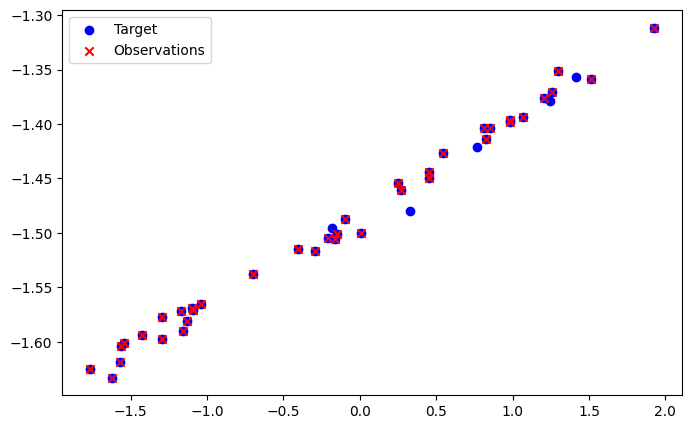

In [9]:
data_generator.plot_first_elt_of_random_batch()

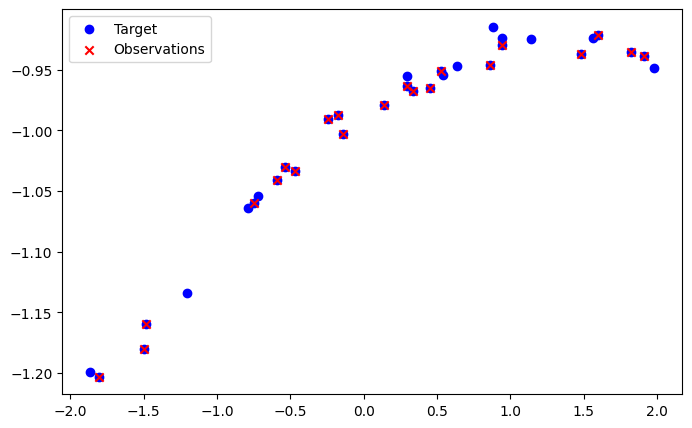

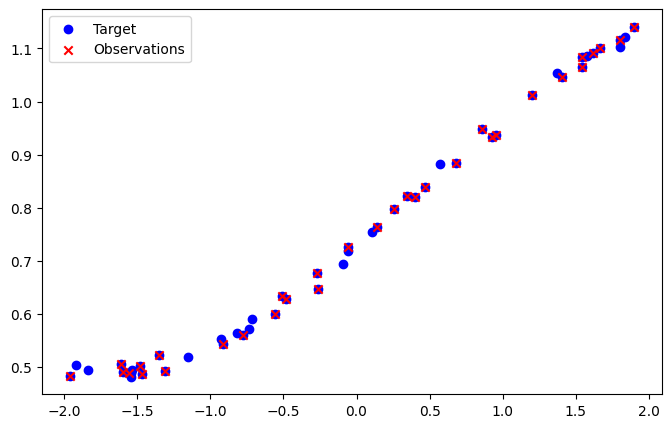

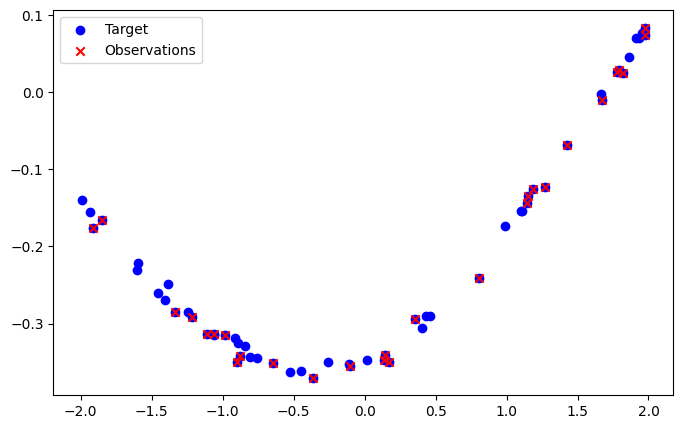

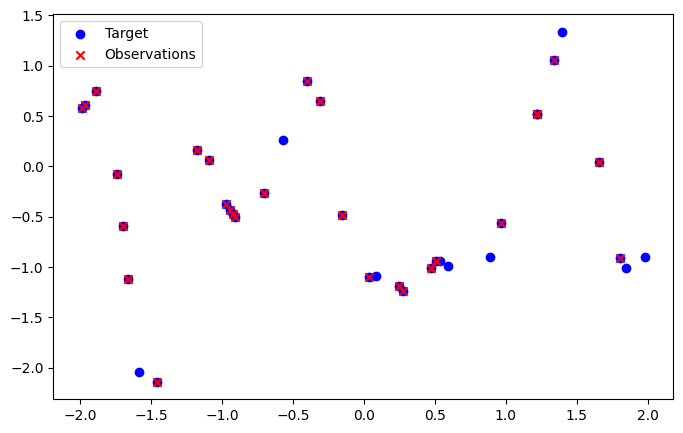

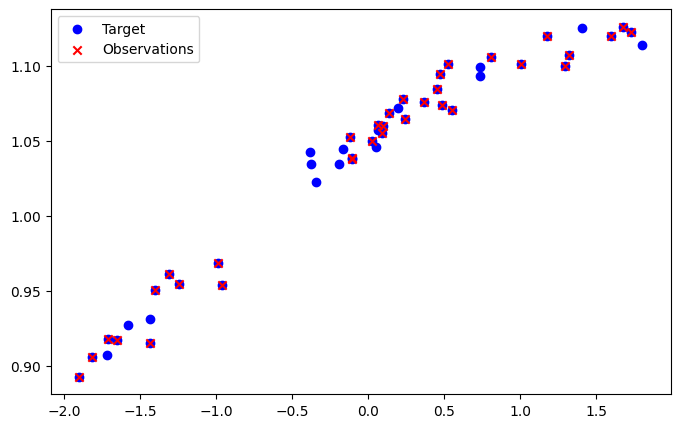

In [11]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGeneratorArbitraryGPWithVaryingKernel.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)

# Train CNP

In [34]:
encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [35]:
callbacks = []

log_dir = f'logs/cnp/regression/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5)

callbacks.append(tensorboard_callback)

# callbacks.append(
#     tf.keras.callbacks.EarlyStopping(
#         patience=20,
#         monitor="val_loss",
#         mode="min",
#         restore_best_weights=True)
#     )

In [36]:
history = model.fit(data_generator.train_ds,
                    validation_data=data_generator.test_ds,
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 15s 571ms/step - loss: 0.9273 - val_loss: 0.5756
Epoch 2/100
25/25 [==============================] - 14s 551ms/step - loss: 0.5316 - val_loss: 0.6272
Epoch 3/100
25/25 [==============================] - 12s 478ms/step - loss: 0.7491 - val_loss: 0.6557
Epoch 4/100
25/25 [==============================] - 12s 480ms/step - loss: 0.5211 - val_loss: 0.5427
Epoch 5/100
25/25 [==============================] - 13s 509ms/step - loss: 0.5913 - val_loss: 0.3307
Epoch 6/100
25/25 [==============================] - 12s 467ms/step - loss: 0.4027 - val_loss: 0.4281
Epoch 7/100
25/25 [==============================] - 11s 461ms/step - loss: 0.2491 - val_loss: 0.1529
Epoch 8/100
25/25 [==============================] - 11s 456ms/step - loss: 0.6464 - val_loss: 0.5622
Epoch 9/100
25/25 [==============================] - 10s 411ms/step - loss: 0.6115 - val_loss: 0.4203
Epoch 10/100
25/25 [==============================] - 11s 435ms/step - loss: 0.492

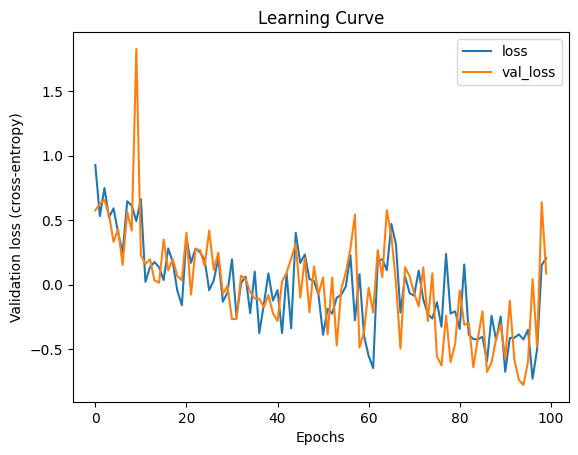

In [37]:
plot_learning_curve(history)

# Plot

1/1 [==============================] - 0s 44ms/step


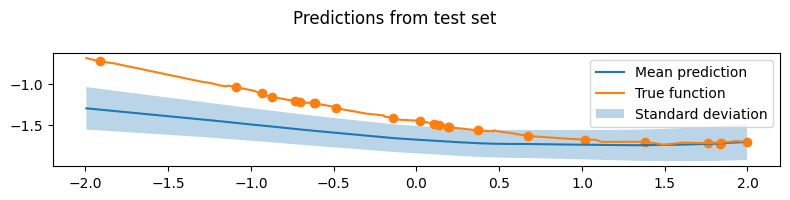

In [38]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=1)

1/1 [==============================] - 0s 40ms/step


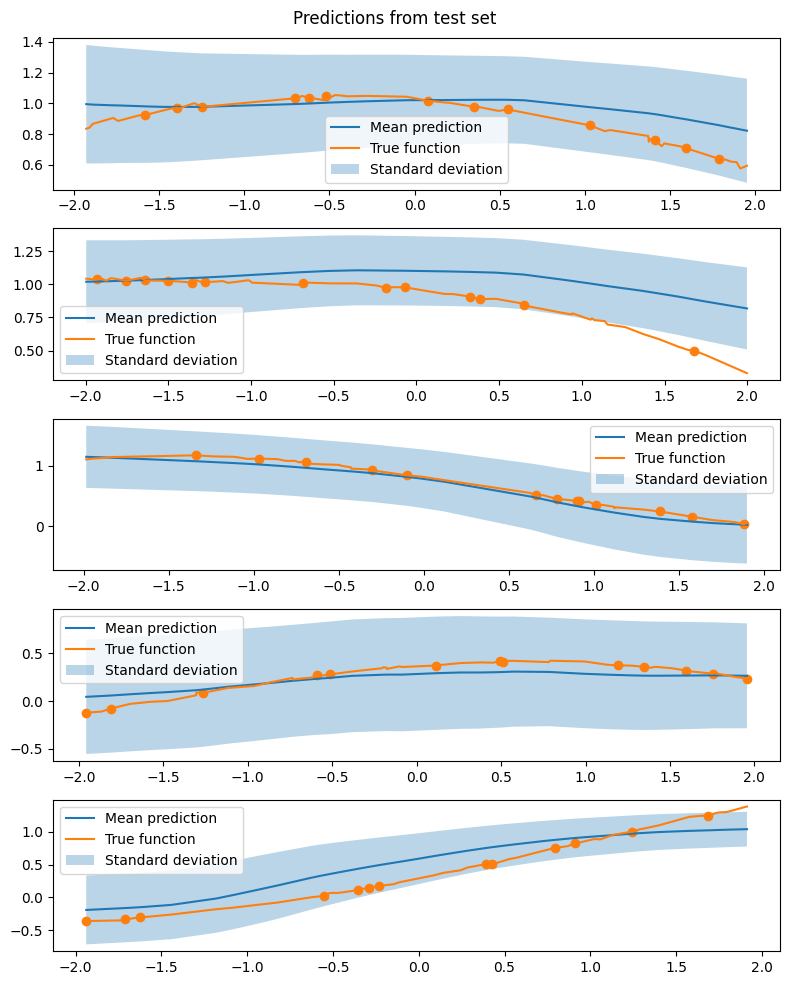

In [39]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=5)

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from dataloader.load_regression_data_from_arbitrary_gp_varying_kernel import draw_single_example_from_arbitrary_gp
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_single_example

1/1 [==============================] - 0s 27ms/step


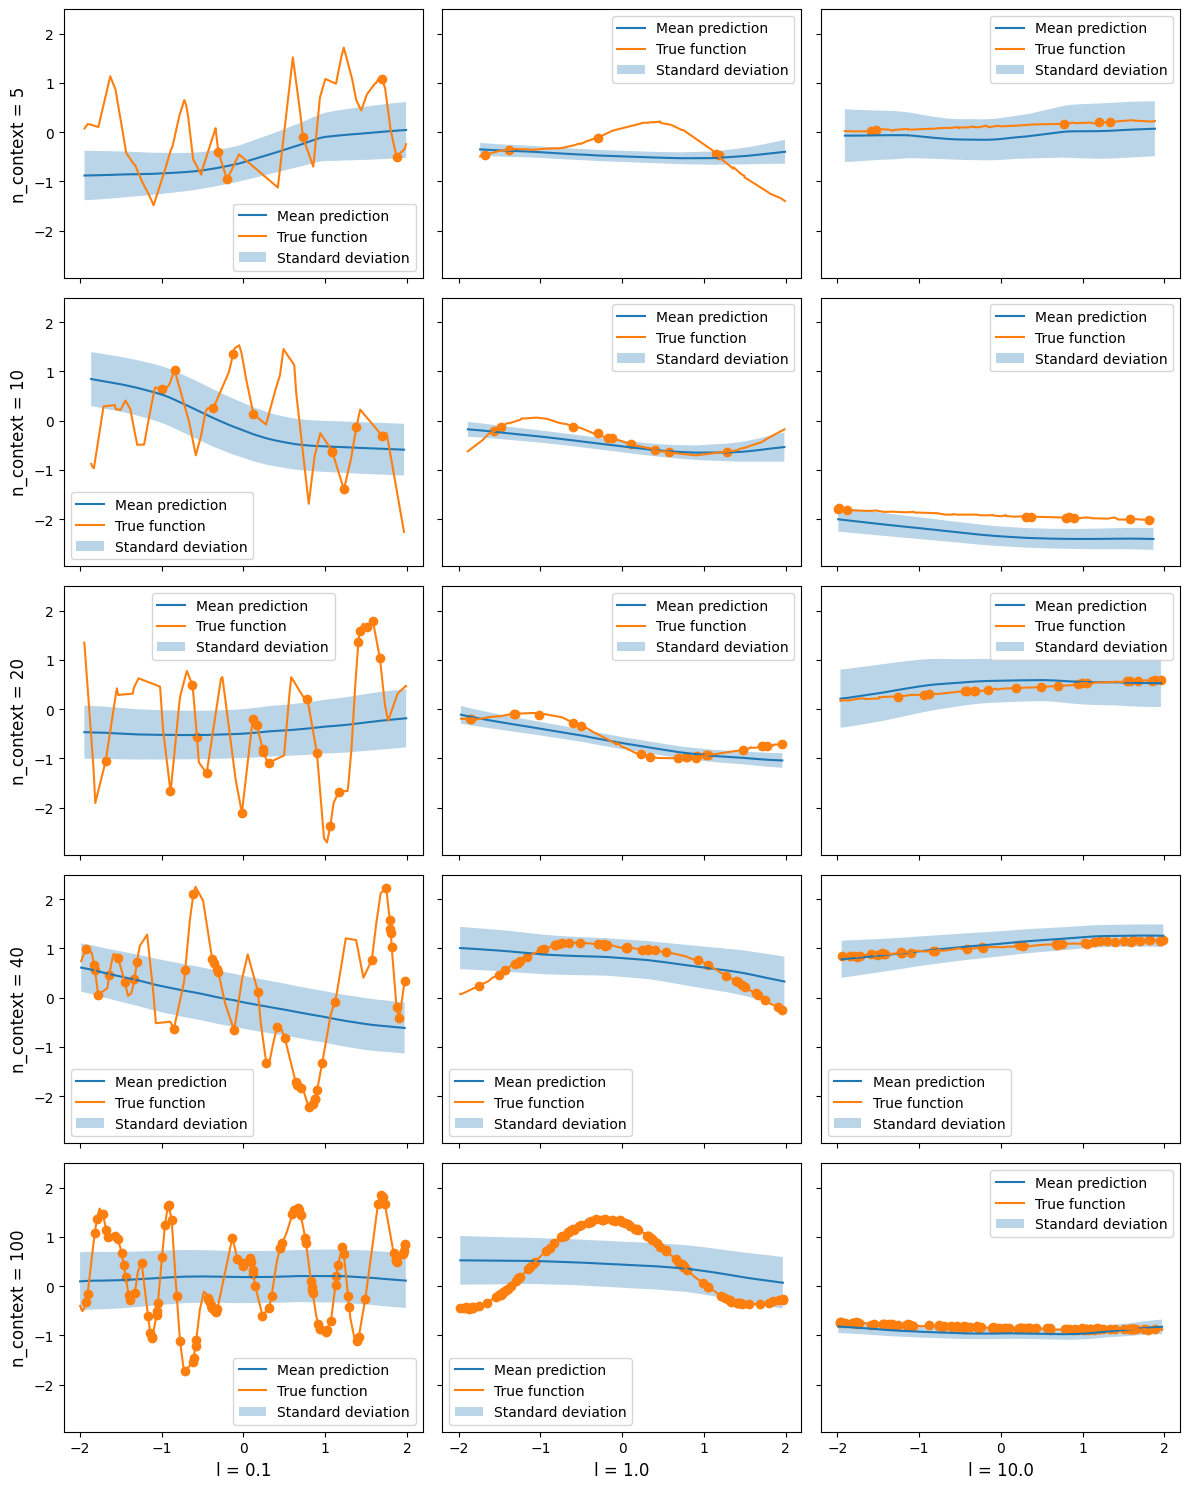

In [43]:
list_num_context = [5, 10, 20, 40, 100]
list_kernel_length_scale = [0.1, 1., 10.]

fig, axis = plt.subplots(len(list_num_context), len(list_kernel_length_scale),
                         figsize=(4*len(list_kernel_length_scale), 3*len(list_num_context)),
                         sharex=True,
                         sharey=True)

for idx_row, num_context in enumerate(list_num_context):
    for idx_col, kernel_length_scale in enumerate(list_kernel_length_scale):
        (context_x, context_y, target_x), target_y = draw_single_example_from_arbitrary_gp(
            kernel_length_scale=kernel_length_scale,
            num_context=num_context,
            num_target=50
        )
    
        plot_preds_from_single_example(model, context_x, context_y, target_x, target_y,
                                       show_title=False, ax=axis[idx_row, idx_col])

        
for ax, label in zip(axis[:,0], [f"n_context = {n}" for n in list_num_context]):
    ax.set_ylabel(label, rotation=90, size='large')
        
for ax, label in zip(axis[-1,:], [f"l = {l}" for l in list_kernel_length_scale]):
    ax.set_xlabel(label, rotation=0, size='large')

fig.tight_layout()